In [1]:
import torch
import torch.nn as nn
import numpy as np
import mne

from braindecode.datasets.sleep_physionet import SleepPhysionet

%matplotlib qt

In [2]:
dataset = SleepPhysionet(subject_ids=[0, 1], recording_ids=[1], crop_wake_mins=30)

Extracting EDF parameters from /mnt/285EDDF95EDDC02C/Users/Public/Documents/mne_data/physionet-sleep-data/SC4001E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /mnt/285EDDF95EDDC02C/Users/Public/Documents/mne_data/physionet-sleep-data/SC4011E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


In [3]:
dataset.description

,subject,recording
0,0,1
1,1,1


In [4]:
raw = dataset.datasets[0].raw

In [5]:
raw.info

<Info | 7 non-empty values
 bads: []
 ch_names: Fpz-Cz, Pz-Oz
 chs: 2 EEG
 custom_ref_applied: False
 highpass: 0.5 Hz
 lowpass: 100.0 Hz
 meas_date: 1989-04-24 16:13:00 UTC
 nchan: 2
 projs: []
 sfreq: 100.0 Hz
>

In [6]:
n_time_samps = raw.n_times
time_secs = raw.times
ch_names = raw.ch_names
n_chan = len(ch_names)

print('The (cropped) sample data object has {} time samples and {} channels.'
      ''.format(n_time_samps, n_chan))
print('The last time sample is at {} seconds.'.format(time_secs[-1]))
print('The channel names are {}.'.format(', '.join(ch_names)))

The (cropped) sample data object has 2508001 time samples and 2 channels.
The last time sample is at 25080.0 seconds.
The channel names are Fpz-Cz, Pz-Oz.


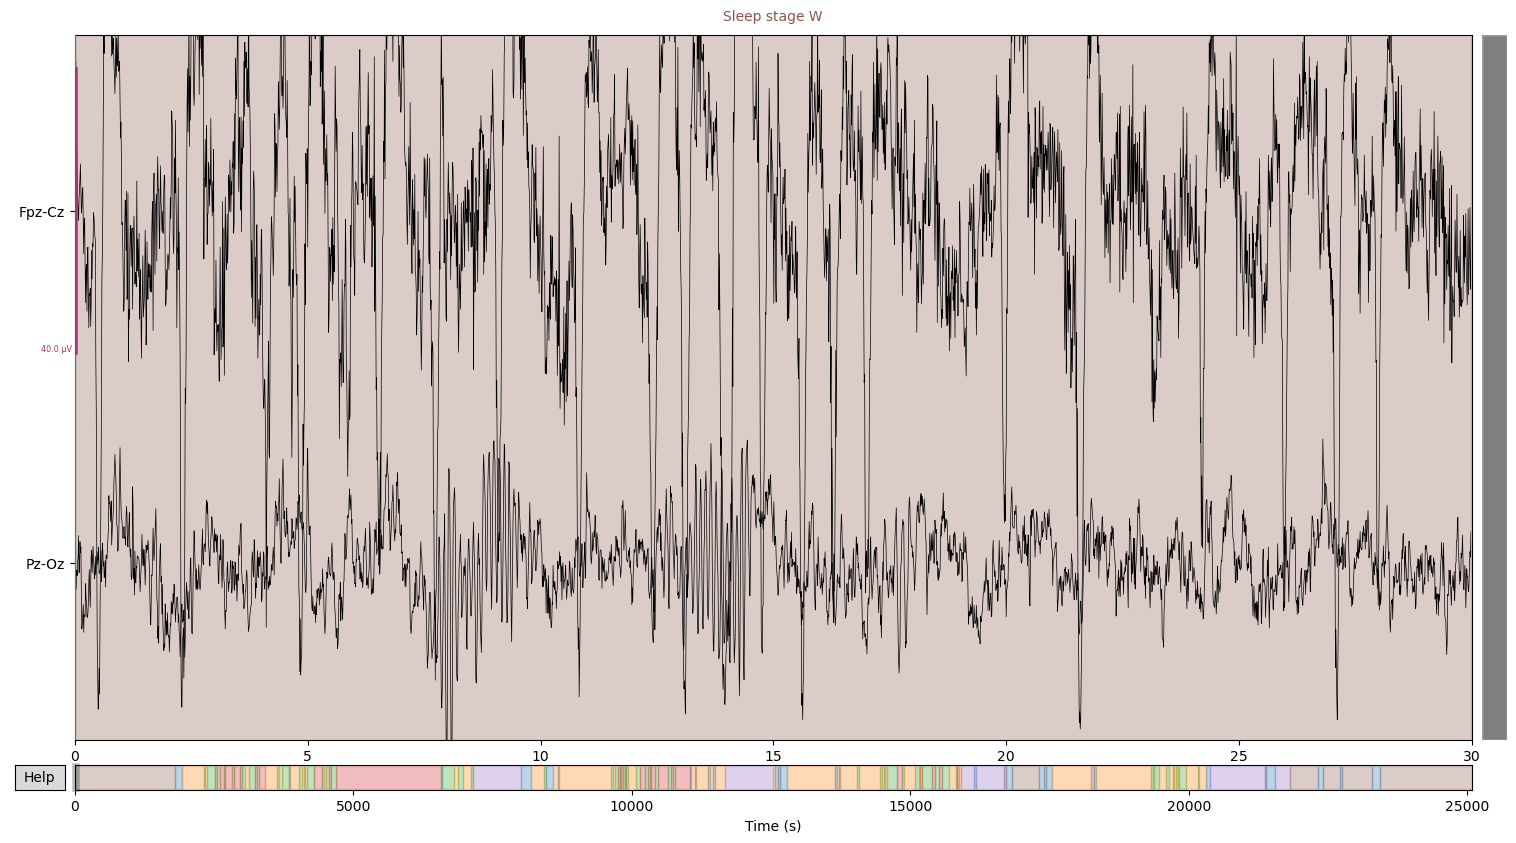

In [7]:
raw.plot(duration=30)

In [8]:
from braindecode.datautil.preprocess import (
    MNEPreproc, NumpyPreproc, preprocess)

high_cut_hz = 30

preprocessors = [
    # convert from volt to microvolt, directly modifying the numpy array
    NumpyPreproc(fn=lambda x: x * 1e6),
    # bandpass filter
    MNEPreproc(fn='filter', l_freq=None, h_freq=high_cut_hz),
]

# Transform the data
preprocess(dataset, preprocessors)

Reading 0 ... 2508000  =      0.000 ... 25080.000 secs...
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)

Reading 0 ... 3261000  =      0.000 ... 32610.000 secs...
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45

In [9]:
from braindecode.datautil.windowers import create_windows_from_events


mapping = {  # We merge stages 3 and 4 following AASM standards.
    'Sleep stage W': 0,
    'Sleep stage 1': 1,
    'Sleep stage 2': 2,
    'Sleep stage 3': 3,
    'Sleep stage 4': 3,
    'Sleep stage R': 4
}

window_size_s = 300
sfreq = 100
window_size_samples = window_size_s * sfreq

windows_dataset = create_windows_from_events(
    dataset, trial_start_offset_samples=0, trial_stop_offset_samples=0,
    window_size_samples=window_size_samples,
    window_stride_samples=window_size_samples, preload=True, mapping=mapping)

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Adding metadata with 4 columns
Replacing existing metadata with 4 columns
192 matching events found
No baseline correction applied
0 projection items activated
Loading data for 192 events and 30000 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Adding metadata with 4 columns
Replacing existing metadata with 4 columns
191 matching events found
No baseline correction applied
0 projection items activated
Loading data for 191 events and 30000 original time points ...
0 bad epochs dropped


In [10]:
from braindecode.datautil.preprocess import zscore

preprocess(windows_dataset, [MNEPreproc(fn=zscore)])

In [11]:
splitted = windows_dataset.split('subject')
train_set = splitted['0']
valid_set = splitted['1']

# Print number of examples per class
print(train_set.datasets[0].windows)
print(valid_set.datasets[0].windows)

<Epochs |  192 events (all good), 0 - 299.99 sec, baseline off, ~87.9 MB, data loaded, with metadata,
 'Sleep stage 1': 24
 'Sleep stage 2': 52
 'Sleep stage 3': 77
 'Sleep stage 4': 77
 'Sleep stage R': 14
 'Sleep stage W': 25>
<Epochs |  191 events (all good), 0 - 299.99 sec, baseline off, ~87.4 MB, data loaded, with metadata,
 'Sleep stage 1': 35
 'Sleep stage 2': 78
 'Sleep stage 3': 33
 'Sleep stage 4': 33
 'Sleep stage R': 21
 'Sleep stage W': 24>


In [12]:
train_set[0]

(array([[ 0.31287974,  0.759502  ,  0.70105046, ...,  0.48812708,
          0.5785183 ,  0.6262975 ],
        [-0.18912518, -0.24105646, -0.5359567 , ...,  0.23181352,
          0.26801884,  0.1259037 ]], dtype=float32),
 0,
 [0, 2883000, 2913000])

In [13]:
# train_set.datasets[0].windows.plot(n_epochs=1)

In [14]:
from braindecode.util import set_random_seeds
from braindecode.models import SleepStagerChambon2018

cuda = torch.cuda.is_available()  # check if GPU is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if cuda:
    torch.backends.cudnn.benchmark = True
# Set random seed to be able to reproduce results
set_random_seeds(seed=87, cuda=cuda)

n_classes = 5
# Extract number of channels and time steps from dataset
n_channels = train_set[0][0].shape[0]
input_size_samples = train_set[0][0].shape[1]

model = SleepStagerChambon2018(
    n_channels,
    sfreq,
    n_classes=n_classes,
    input_size_s=input_size_samples / sfreq
)

# Send model to GPU
if cuda:
    model.cuda()

In [15]:
from skorch.helper import predefined_split
from skorch.callbacks import EpochScoring
from braindecode import EEGClassifier

lr = 5e-4
batch_size = 16
n_epochs = 5

train_bal_acc = EpochScoring(
    scoring='balanced_accuracy', on_train=True, name='train_bal_acc',
    lower_is_better=False)
valid_bal_acc = EpochScoring(
    scoring='balanced_accuracy', on_train=False, name='valid_bal_acc',
    lower_is_better=False)
callbacks = [('train_bal_acc', train_bal_acc),
             ('valid_bal_acc', valid_bal_acc)]

clf = EEGClassifier(
    model,
    criterion=torch.nn.CrossEntropyLoss,
    optimizer=torch.optim.Adam,
    train_split=predefined_split(valid_set),  # using valid_set for validation
    optimizer__lr=lr,
    batch_size=batch_size,
    callbacks=callbacks,
    device=device
)
# Model training for a specified number of epochs. `y` is None as it is already
# supplied in the dataset.
clf.fit(train_set, y=None, epochs=n_epochs)

  epoch    train_bal_acc    train_loss    valid_bal_acc    valid_loss     dur
-------  ---------------  ------------  ---------------  ------------  ------
      1           0.1803        1.4487           0.2089        1.4980  1.3853
      2           0.2201        1.3176           0.2000        1.5167  0.3320
      3           0.2038        1.1883           0.2000        1.5263  0.3343
      4           0.2256        1.0946           0.2359        1.4111  0.3338
      5           0.2901        1.0010           0.2615        1.3968  0.3393


<class 'braindecode.classifier.EEGClassifier'>[initialized](
  module_=SleepStagerChambon2018(
    (spatial_conv): Conv2d(1, 2, kernel_size=(2, 1), stride=(1, 1))
    (feature_extractor): Sequential(
      (0): Conv2d(1, 8, kernel_size=(1, 50), stride=(1, 1), padding=(0, 25))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=(1, 12), stride=(1, 12), padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(8, 8, kernel_size=(1, 50), stride=(1, 1), padding=(0, 25))
      (4): ReLU()
      (5): MaxPool2d(kernel_size=(1, 12), stride=(1, 12), padding=0, dilation=1, ceil_mode=False)
    )
    (fc): Sequential(
      (0): Dropout(p=0.25, inplace=False)
      (1): Linear(in_features=3328, out_features=5, bias=True)
    )
  ),
)

In [16]:
class VectorQuantizerEMA(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost, decay, epsilon=1e-5):
        super(VectorQuantizerEMA, self).__init__()
        
        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings
        
        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.normal_()
        self._commitment_cost = commitment_cost
        
        self.register_buffer('_ema_cluster_size', torch.zeros(num_embeddings))
        self._ema_w = nn.Parameter(torch.Tensor(num_embeddings, self._embedding_dim))
        self._ema_w.data.normal_()
        
        self._decay = decay
        self._epsilon = epsilon

    def forward(self, inputs):
        # convert inputs from BCHW -> BHWC
        inputs = inputs.permute(0, 2, 3, 1).contiguous()
        input_shape = inputs.shape
        
        # Flatten input
        flat_input = inputs.view(-1, self._embedding_dim)
        
        # Calculate distances
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True) 
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t()))
            
        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)
        
        # Quantize and unflatten
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)
        
        # Use EMA to update the embedding vectors
        if self.training:
            self._ema_cluster_size = self._ema_cluster_size * self._decay + \
                                     (1 - self._decay) * torch.sum(encodings, 0)
            
            # Laplace smoothing of the cluster size
            n = torch.sum(self._ema_cluster_size.data)
            self._ema_cluster_size = (
                (self._ema_cluster_size + self._epsilon)
                / (n + self._num_embeddings * self._epsilon) * n)
            
            dw = torch.matmul(encodings.t(), flat_input)
            self._ema_w = nn.Parameter(self._ema_w * self._decay + (1 - self._decay) * dw)
            
            self._embedding.weight = nn.Parameter(self._ema_w / self._ema_cluster_size.unsqueeze(1))
        
        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        loss = self._commitment_cost * e_latent_loss
        
        # Straight Through Estimator
        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))
        
        # convert quantized from BHWC -> BCHW
        return loss, quantized.permute(0, 3, 1, 2).contiguous(), perplexity, encodings



In [18]:
import torch.nn as nn
from torch.nn import functional as F


class AlignementModule(nn.Module):
    def __init__(self, similarity_type="l2", temperature=1.):
        super(AlignementModule, self).__init__()
        
        self.similarity_type = similarity_type
        self.temperature = temperature
    
    def forward(self, embs, steps=None, seq_lens=None):
        
        batch_size = embs.shape[0]
        num_steps = embs.shape[1]

        if steps is None:
            steps = torch.arange(num_steps).unsqueeze(0).expand((batch_size, -1)).to(embs.device)
        if seq_lens is None:
            seq_lens = torch.LongTensor([num_steps]*batch_size).to(embs.device)

        labels_list = []
        logits_list = []
        steps_list = []
        seq_lens_list = []

        for i in range(batch_size):
            for j in range(batch_size):
                # We do not align the sequence with itself.
                if i != j:
                    logits, labels = self.align_pair_of_sequences(embs[i],
                                                                  embs[j],
                                                                  self.similarity_type,
                                                                  self.temperature)
                    logits_list.append(logits)
                    labels_list.append(labels)
                    steps_list.append(steps[i:i+1].expand([num_steps, -1]))
                    seq_lens_list.append(seq_lens[i:i+1].expand([num_steps]))

        logits = torch.cat(logits_list)
        labels = torch.cat(labels_list)
        steps = torch.cat(steps_list)
        seq_lens = torch.cat(seq_lens_list)
        
        return logits, labels, steps, seq_lens
    
    def pairwise_l2_distance(self, x, y=None):
        x_norm = (x**2).sum(1).view(-1, 1)
        if y is not None:
            y_t = torch.transpose(y, 0, 1)
            y_norm = (y**2).sum(1).view(1, -1)
        else:
            y_t = torch.transpose(x, 0, 1)
            y_norm = x_norm.view(1, -1)

        dist = x_norm + y_norm - 2.0 * torch.mm(x, y_t)
        # Ensure diagonal is zero if x=y
        if y is None:
            dist = dist - torch.diag(dist.diag)
        return torch.clamp(dist, 0.0, np.inf)


    def get_scaled_similarity(self, embs1, embs2, similarity_type, temperature):
        channels = float(embs1.shape[1])
        # Go for embs1 to embs2.
        if similarity_type == 'cosine':
            similarity = torch.matmul(embs1, embs2.T)
        elif similarity_type == 'l2':
            similarity = -1.0 * self.pairwise_l2_distance(embs1, embs2)
        else:
            raise ValueError('similarity_type can either be l2 or cosine.')

        # Scale the distance  by number of channels. This normalization helps with
        # optimization.
        similarity /= channels
        # Scale the distance by a temperature that helps with how soft/hard the
        # alignment should be.
        similarity /= temperature

        return similarity


    def align_pair_of_sequences(self, embs1, embs2, similarity_type, temperature):
        max_num_steps = embs1.shape[0]

        # Find distances between embs1 and embs2.
        sim_12 = self.get_scaled_similarity(embs1, embs2, similarity_type, temperature)
        # Softmax the distance.
        softmaxed_sim_12 = F.softmax(sim_12, dim=1)

        # Calculate soft-nearest neighbors.
        nn_embs = torch.matmul(softmaxed_sim_12, embs2)

        # Find distances between nn_embs and embs1.
        sim_21 = self.get_scaled_similarity(nn_embs, embs1, similarity_type, temperature)

        logits = sim_21
        labels = torch.arange(max_num_steps).to(sim_21.device)

        return logits, labels


class TCCLoss(nn.Module):
    def __init__(self, variance_lambda, loss_type='var', normalize_indices=True, label_smoothing=0.):
        super(TCCLoss, self).__init__()
        
        self.variance_lambda = variance_lambda
        self.loss_type = loss_type
        self.normalize_indices = normalize_indices
        self.label_smoothing = label_smoothing
    
    def forward(self, logits, labels, steps, seq_lens):
        num_steps = steps.shape[1]
        
        classification_loss = torch.mean(F.cross_entropy(logits, labels))
        
        seq_lens = seq_lens.float()
        
        if self.normalize_indices:
            tile_seq_lens = seq_lens.unsqueeze(1).expand([-1, num_steps])
            steps = steps / tile_seq_lens
        
        beta = F.softmax(logits, dim=1)
        true_time = torch.sum(steps * labels.unsqueeze(1), dim=1)
        pred_time = torch.sum(steps * beta, dim=1)

        if 'var' in self.loss_type:
            # Variance aware regression.
            pred_time_tiled = pred_time.unsqueeze(1).expand([-1, num_steps])

            pred_time_variance = torch.sum((steps - pred_time_tiled)**2 * beta, dim=1)

            # Using log of variance as it is numerically stabler.
            pred_time_log_var = torch.log(pred_time_variance + 1e-16)
            squared_error = (true_time - pred_time)**2
            regression_loss = torch.mean(torch.exp(-pred_time_log_var) * squared_error
                                + self.variance_lambda * pred_time_log_var)
        else:
            regression_loss = torch.mean(F.mse_loss(pred_time, true_time))
        
        return classification_loss + regression_loss

In [19]:
inputs = torch.FloatTensor(np.random.random(4*10*16).reshape(4,10,16))

In [20]:
am = AlignementModule()
logits, labels, steps, seq_lens = am(inputs)

In [21]:
logits.shape, labels.shape

(torch.Size([120, 10]), torch.Size([120]))

In [22]:
tcc = TCCLoss(variance_lambda=0.1, loss_type='var')
loss = tcc(logits, labels, steps, seq_lens)

In [23]:
loss

tensor(6778.6821)

In [24]:
from braindecode.datasets.base import BaseDataset, BaseConcatDataset

class WindowsDataset(BaseDataset):
    """Applies a windower to a base dataset.
    Parameters
    ----------
    windows: mne.Epochs
        windows obtained through the application of a windower to a
        BaseDataset
    description: dict | pandas.Series | None
        holds additional info about the windows
    """
    def __init__(self, windows, description=None):
        self.windows = windows
        self.description = _create_description(description)
        self.y = np.array(self.windows.metadata.loc[:, 'target'])
        self.crop_inds = np.array(self.windows.metadata.loc[:,
                                  ['i_window_in_trial', 'i_start_in_trial','i_stop_in_trial']])

    def __getitem__(self, index):
        X = self.windows.get_data(item=index)[0].astype('float32')
        y = self.y[index]
        # necessary to cast as list to get list of
        # three tensors from batch, otherwise get single 2d-tensor...
        crop_inds = list(self.crop_inds[index])
        return X, y, crop_inds

    def __len__(self):
        return len(self.windows.events)

In [25]:
windows_dataset.datasets[0].windows.get_data().shape

(192, 2, 30000)

In [26]:
import bisect

class StackDataset(BaseConcatDataset):
    """A base class for concatenated datasets. Holds either mne.Raw or
    mne.Epoch in self.datasets and has a pandas DataFrame with additional
    description.
    Parameters
    ----------
    list_of_ds: list
        list of BaseDataset, BaseConcatDataset or WindowsDataset
    """
    def __init__(self, list_of_ds):
        super(StackDataset, self).__init__(list_of_ds)
    
    def __len__(self):
        return len(self.datasets)
    
    def __getitem__(self, index):
        X, y, crop_inds = zip(*[self.datasets[index][i] for i in range(len(self.datasets[index]))])
        return np.array(X), np.array(y), np.array(crop_inds)

class TimeContrastiveDataset(BaseConcatDataset):
    """A base class for concatenated datasets. Holds either mne.Raw or
    mne.Epoch in self.datasets and has a pandas DataFrame with additional
    description.
    Parameters
    ----------
    list_of_ds: list
        list of BaseDataset, BaseConcatDataset or WindowsDataset
    """
    def __init__(self, list_of_ds):
        super(TimeContrastiveDataset, self).__init__(list_of_ds)
    
    def __getitem__(self, idx):
        if idx < 0:
            if -idx > len(self):
                raise ValueError("absolute value of index should not exceed dataset length")
            idx = len(self) + idx
        dataset_idx = bisect.bisect_right(self.cumulative_sizes, idx)
        if dataset_idx == 0:
            anchor_sample_idx = idx
        else:
            anchor_sample_idx = idx - self.cumulative_sizes[dataset_idx - 1]

        dataset_size = len(self.datasets[dataset_idx])
        contrastive_sample_idx = anchor_sample_idx
        while contrastive_sample_idx == anchor_sample_idx:
            contrastive_sample_idx = np.random.choice(np.arange(dataset_size))
        
        anchor_sample = self.datasets[dataset_idx][anchor_sample_idx]
        contastive_sample = self.datasets[dataset_idx][contrastive_sample_idx]
        
        X, _, crop_inds = list(zip(*[anchor_sample, contastive_sample]))
        X = np.array(X)
        crop_inds = np.array(crop_inds)
        y = int(contrastive_sample_idx > anchor_sample_idx)
        
        return X, y, crop_inds

In [27]:
stacked_dataset = StackDataset([windows_dataset])

In [28]:
stacked_dataset[0][2].shape

(192, 3)

In [29]:
class StagerNet(torch.nn.Module):
    def __init__(self, nb_channels, p_dropout):
        """
        nb_channels: number of EEG channels.
        p_dropout: used for training, probability of dropout of the second-last layer.
        """
        super(StagerNet, self).__init__()
        self.spat_conv = nn.Conv2d(in_channels=1, out_channels=nb_channels, kernel_size=(nb_channels,1))
        self.temp_conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(1,50))
        self.max_pool1 = nn.MaxPool2d(kernel_size=(1,13), stride=(1,13))
        self.temp_conv2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(1,50))
        self.max_pool2 = nn.MaxPool2d(kernel_size=(1,13), stride=(1,13))
        self.dropout = nn.Dropout(p=p_dropout)
        self.dense = nn.Linear(in_features=nb_channels*16*13, out_features=100)
        self.lin_reg = nn.Linear(in_features=2*100, out_features=1)
        
    
    def forward(self,x):
        """
        Input shape: (batch_size, 2, 1, nb_channels, 3000)
        Output shape: (batch_size, 1)
        """
        x1,x2 = x[:,0,:,:,:], x[:,1,:,:,:]
        x1 = self.encoder(x1)
        x2 = self.encoder(x2)
        x = torch.cat((x1, x2), dim=1)
        x = self.lin_reg(x)
        x = nn.Sigmoid()(x)
        return x
    
    def encoder(self,x):
        """
        Input shape: (batch_size, 1, nb_channels, 3000)
        Output shape: (batch_size, 100)
        """
        x = self.spat_conv(x)
        x = x.transpose(1,2)
        x = self.temp_conv1(x)
        x = self.max_pool1(x)
        x = nn.ReLU()(x)
        x = self.temp_conv2(x)
        x = self.max_pool2(x)
        x = nn.ReLU()(x)
        x = nn.Flatten()(x)
        x = self.dropout(x)
        x = self.dense(x)
        return x
